In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

In [2]:
def smooth_series(series, window=3):
    return pd.Series(series).rolling(window=window, min_periods=1, center=True).mean().to_numpy()

> Plot humans and AVs. Find the mean of the 3 experiments and plot the error bar using different std values for the values > mean and values < mean.

In [ ]:
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'


# Set your actual parent directory here
parent_dir = os.path.abspath('results/scenario1')

# Define suffixes and their readable labels
group_suffixes = ['_ipp', '_iql', '_map', '_qmi']
suffix_labels = {
    '_ipp': 'IPPO',
    '_iql': 'IQL',
    '_map': 'MAPPO',
    '_qmi': 'QMIX'
}

# Define city prefixes and their readable names
city_prefixes = {
    'ing': 'Ingolstadt',
    'pro': 'Provins',
    'sai': 'Saint Arnoult'
}

# Define color palette for algorithms
colors = ["firebrick", "teal", "peru", "navy", "salmon", "slategray", "darkviolet"]
color_map = {suffix: colors[i] for i, suffix in enumerate(group_suffixes)}

# Group folders by city and algorithm
city_groups = defaultdict(lambda: defaultdict(list))
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            if folder.startswith(f'{city_prefix}_'):
                for suffix in group_suffixes:
                    if suffix in folder:
                        city_groups[city_prefix][suffix].append(folder_path)
                        break

# Helper: get average AV travel times per folder
def get_av_travel_times(folder_path):
    times = []
    episode_folder = os.path.join(folder_path, 'episodes')
    csv_files = sorted(glob.glob(os.path.join(episode_folder, 'ep*.csv')))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'kind' in df.columns and 'travel_time' in df.columns:
                av_df = df[df['kind'] == 'AV']
                avg_travel_time = av_df['travel_time'].mean()
                times.append(avg_travel_time)
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    return times


def get_travel_times_by_kind(folder_path, agent_kind):
    times = []
    episode_folder = os.path.join(folder_path, 'episodes')
    csv_files = sorted(glob.glob(os.path.join(episode_folder, 'ep*.csv')))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'kind' in df.columns and 'travel_time' in df.columns:
                subset = df[df['kind'] == agent_kind]
                avg_travel_time = subset['travel_time'].mean()
                times.append(avg_travel_time)
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    return times


def compute_asymmetric_stats(all_runs, max_len):
    # Pad with NaN for unequal lengths
    padded = [run + [np.nan] * (max_len - len(run)) for run in all_runs]
    data = np.array(padded)

    # Compute mean across folders
    with np.errstate(invalid='ignore'):
        mean = np.nanmean(data, axis=0)

    # Compute std dev above and below mean
    upper_std = np.full_like(mean, np.nan)
    lower_std = np.full_like(mean, np.nan)
    for i in range(data.shape[1]):
        col = data[:, i]
        col = col[~np.isnan(col)]
        above = col[col > mean[i]]
        below = col[col < mean[i]]
        upper_std[i] = np.std(above) if len(above) > 0 else 0
        lower_std[i] = np.std(below) if len(below) > 0 else 0

    return mean, lower_std, upper_std


# Create subplots (3 cities)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # No sharey

for i, (city_prefix, alg_groups) in enumerate(city_groups.items()):
    ax = axes[i]
    city_name = city_prefixes[city_prefix]

    for suffix, folders in alg_groups.items():
        # Gather data for AVs and Humans
        av_runs = [get_travel_times_by_kind(folder, 'AV') for folder in folders]
        human_runs = [get_travel_times_by_kind(folder, 'Human') for folder in folders]
        
        if not av_runs or not human_runs:
            continue

        max_len = max(max(len(run) for run in av_runs), max(len(run) for run in human_runs))
        
        # AV mean & std
        mean_av, lower_std, upper_std = compute_asymmetric_stats(av_runs, max_len)
        mean_av_smooth = smooth_series(mean_av, window=10)
        lower_smooth = smooth_series(mean_av - lower_std, window=10)
        upper_smooth = smooth_series(mean_av + upper_std, window=10)

        # Human mean (no shading)
        padded_human = [run + [np.nan] * (max_len - len(run)) for run in human_runs]
        mean_human = np.nanmean(padded_human, axis=0)
        mean_human_smooth = smooth_series(mean_human, window=10)

        # Plot
        label = suffix_labels.get(suffix, suffix.upper())
        color = color_map.get(suffix, None)
        x = list(range(len(mean_av)))

        # Generate x-axis based on 5-episode intervals
        x = [i * 5 for i in range(len(mean_av))]

        # AV plot with error bands
        ax.plot(x, mean_av_smooth, label=f'{label} (AV)', color=color)
        ax.fill_between(x, lower_smooth, mean_av_smooth, color=color, alpha=0.25)
        ax.fill_between(x, mean_av_smooth, upper_smooth, color=color, alpha=0.25)

        # Human plot
        ax.plot(x, mean_human_smooth, label=f'{label} (Human)', color=color, linestyle='--')

    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(f"{city_name}", fontsize=24)
    ax.set_xlabel("Episode", fontsize=16)
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Mean AV Travel Time", fontsize=16)
        ax.legend(title="", loc = 'upper left', fontsize=14)


> Plot humans and AVs. Find the mean of the 3 experiments and plot the error bar using different std values for the values > mean and values < mean.

Functions

In [3]:
# Helper: get average AV travel times per folder
def get_av_travel_times(folder_path):
    times = []
    episode_folder = os.path.join(folder_path, 'episodes')
    csv_files = sorted(glob.glob(os.path.join(episode_folder, 'ep*.csv')))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'kind' in df.columns and 'travel_time' in df.columns:
                av_df = df[df['kind'] == 'AV']
                avg_travel_time = av_df['travel_time'].mean()
                times.append(avg_travel_time)
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    return times


def get_travel_times_by_kind(folder_path, agent_kind):
    times = []
    episode_folder = os.path.join(folder_path, 'episodes')
    csv_files = sorted(glob.glob(os.path.join(episode_folder, 'ep*.csv')))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'kind' in df.columns and 'travel_time' in df.columns:
                subset = df[df['kind'] == agent_kind]
                avg_travel_time = subset['travel_time'].mean()
                times.append(avg_travel_time)
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    return times


def compute_asymmetric_stats(all_runs, max_len):
    # Pad with NaN for unequal lengths
    padded = [run + [np.nan] * (max_len - len(run)) for run in all_runs]
    data = np.array(padded)

    # Compute mean across folders
    with np.errstate(invalid='ignore'):
        mean = np.nanmean(data, axis=0)

    # Compute std dev above and below mean
    upper_std = np.full_like(mean, np.nan)
    lower_std = np.full_like(mean, np.nan)
    for i in range(data.shape[1]):
        col = data[:, i]
        col = col[~np.isnan(col)]
        above = col[col > mean[i]]
        below = col[col < mean[i]]
        upper_std[i] = np.std(above) if len(above) > 0 else 0
        lower_std[i] = np.std(below) if len(below) > 0 else 0

    return mean, lower_std, upper_std


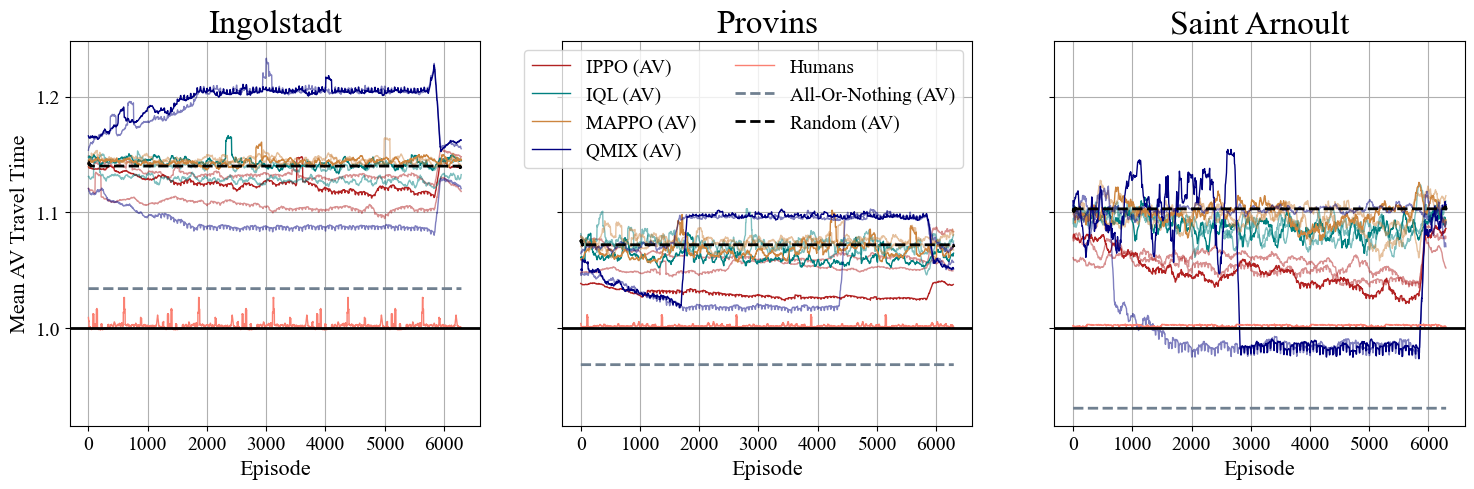

In [32]:
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'


# Set your actual parent directory here
parent_dir = os.path.abspath('results/scenario1')

# Define suffixes and their readable labels
group_suffixes = ['_ipp']#, '_iql', '_map', '_qmi']
suffix_labels = {
    '_ipp': 'IPPO',
    '_iql': 'IQL',
    '_map': 'MAPPO',
    '_qmi': 'QMIX'
}

# Define city prefixes and their readable names
city_prefixes = {
    'ing': 'Ingolstadt',
    'pro': 'Provins',
    'sai': 'Saint Arnoult'
}


# Define known baselines and labels
baseline_suffixes = ['_aon', '_ran']
baseline_labels = {
    '_aon': 'All-Or-Nothing',
    '_ran': 'Random'
}
baseline_styles = {
    '_aon': {'color': 'slategray', 'linestyle': '--'},
    '_ran': {'color': 'black', 'linestyle': '--'}
}

# Define color palette for algorithms
colors = ["firebrick", "teal", "peru", "navy", "salmon", "slategray", "darkviolet"]
color_map = {suffix: colors[i] for i, suffix in enumerate(group_suffixes)}

# Group folders by city and algorithm
city_groups = defaultdict(lambda: defaultdict(list))
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            if folder.startswith(f'{city_prefix}_'):
                for suffix in group_suffixes:
                    if suffix in folder:
                        city_groups[city_prefix][suffix].append(folder_path)
                        break

# Collect baseline folders separately
baseline_groups = defaultdict(dict)
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            for baseline_suffix in baseline_suffixes:
                if folder == f'{city_prefix}{baseline_suffix}':
                    baseline_groups[city_prefix][baseline_suffix] = folder_path

# Create subplots (3 cities)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # No sharey

for i, (city_prefix, alg_groups) in enumerate(city_groups.items()):
    ax = axes[i]
    city_name = city_prefixes[city_prefix]
    avg_human_tt_list = []

    for suffix, folders in alg_groups.items():
        color = color_map.get(suffix, None)
        label = suffix_labels.get(suffix, suffix.upper())

        for idx, folder in enumerate(folders):
            av_run = get_travel_times_by_kind(folder, 'AV')
            human_run = get_travel_times_by_kind(folder, 'Human')

            human_slice = human_run[20:39]  # indices corresponding to episodes 100–200
            avg_human_tt = sum(human_slice) / len(human_slice)
            avg_human_tt_list.append(avg_human_tt)

            av_run = [val / avg_human_tt for val in av_run]

            if not av_run or not human_run:
                continue

            # Smooth and align x-axis
            av_smoothed = smooth_series(av_run, window=20)
            #human_smoothed = smooth_series(human_run, window=10)
            x = [i * 5 for i in range(len(av_smoothed))]

            # Plot each AV run
            if idx == 0:
                ax.plot(x, av_smoothed, label=f'{label} (AV)', color=color, linewidth=1)
            else:
                ax.plot(x, av_smoothed, color=color, linewidth=1, alpha=0.5)

    # Plot the last human agent with dashed line
    human_travel_times = [val / avg_human_tt for val in human_run]
    smooothed_humans = smooth_series(human_travel_times*5, window=20)
    ax.plot(smooothed_humans, label='Humans', color='salmon', linestyle='-', linewidth=1)

    # Compute the avg human tt for all the algorithms
    avg_all_algos_humans_tt = sum(avg_human_tt_list) / len(avg_human_tt_list) 
            
    if city_prefix in baseline_groups:
        for baseline_suffix, folder_path in baseline_groups[city_prefix].items():
            av_times = get_travel_times_by_kind(folder_path, 'AV')
            if not av_times:
                continue
            
            av_times = [val / avg_all_algos_humans_tt for val in av_times]

            original_length = len(av_times)
            j = 0
            while len(av_times) < 5 * len(av_run):
                av_times.append(av_times[j % original_length])
                j += 1

            av_smoothed = smooth_series(av_times, window=100)
            x = [i * 5 for i in range(len(av_smoothed))]

            label = baseline_labels.get(baseline_suffix, baseline_suffix.upper())
            style = baseline_styles.get(baseline_suffix, {'color': 'black', 'linestyle': '--'})

            ax.plot(av_smoothed, label=f'{label} (AV)', **style, linewidth=2)

    

    ax.axhline(y=1, color='black', linestyle='-', linewidth=2)

    ax.tick_params(axis='both', labelsize=14)
    ax.set_yticks([1, 1.1, 1.2])
    ax.set_title(f"{city_name}", fontsize=24)
    ax.set_xlabel("Episode", fontsize=16)
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Mean AV Travel Time", fontsize=16)
    if i == 1:
        ax.legend(title="", loc = 'upper right', fontsize=14, ncol=2)

> With error bars

In [62]:
import os
import pandas as pd

def calculate_extravaganza(folder_path):
    # Filter .csv files with integer names only
    files = []
    for f in os.listdir(folder_path):
        if f.endswith('.csv'):
            name = os.path.splitext(f)[0]
            if name.isdigit():
                files.append(f)
    
    # Sort files numerically
    files_sorted = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))
    
    # Take the last 100 files
    last_100_files = files_sorted[-100:]
    print("last 100 files are: ", last_100_files)
    
    av_travel_times = []

    for filename in last_100_files:
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            if 'kind' in df.columns and 'travel_time' in df.columns:
                av_rows = df[df['kind'] == 'AV']
                av_travel_times.extend(av_rows['travel_time'].dropna().tolist())
            else:
                print(f"Missing required columns in {filename}")
        except Exception as e:
            print(f"Failed to read {filename}: {e}")
    
    # Compute and return the average travel time of AVs
    if av_travel_times:
        return sum(av_travel_times) / len(av_travel_times)
    else:
        print("No AV travel time data found.")
        return None


In [ ]:
from matplotlib import rcParams
from statistics import mean, stdev
import numpy as np

rcParams['font.family'] = 'Times New Roman'

# Set your actual parent directory here
parent_dir = os.path.abspath('results/scenario1')

# Define suffixes and their readable labels
group_suffixes = ['_ipp']#, '_iql', '_map', '_qmi']
suffix_labels = {
    '_ipp': 'IPPO',
    '_iql': 'IQL',
    '_map': 'MAPPO',
    '_qmi': 'QMIX'
}

# Define city prefixes and their readable names
city_prefixes = {
    'ing': 'Ingolstadt',
    'pro': 'Provins',
    'sai': 'Saint Arnoult'
}


# Define known baselines and labels
baseline_suffixes = ['_aon', '_ran']
baseline_labels = {
    '_aon': 'All-Or-Nothing',
    '_ran': 'Random'
}
baseline_styles = {
    '_aon': {'color': 'slategray', 'linestyle': '--'},
    '_ran': {'color': 'black', 'linestyle': '--'}
}

# Define color palette for algorithms
colors = ["firebrick", "teal", "peru", "navy", "salmon", "slategray", "darkviolet"]
color_map = {suffix: colors[i] for i, suffix in enumerate(group_suffixes)}

# Group folders by city and algorithm
city_groups = defaultdict(lambda: defaultdict(list))
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            if folder.startswith(f'{city_prefix}_'):
                for suffix in group_suffixes:
                    if suffix in folder:
                        city_groups[city_prefix][suffix].append(folder_path)
                        break

# Collect baseline folders separately
baseline_groups = defaultdict(dict)
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            for baseline_suffix in baseline_suffixes:
                if folder == f'{city_prefix}{baseline_suffix}':
                    baseline_groups[city_prefix][baseline_suffix] = folder_path

# Create subplots (3 cities)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)

for i, (city_prefix, alg_groups) in enumerate(city_groups.items()):
    ax = axes[i]
    city_name = city_prefixes[city_prefix]
    avg_human_tt_list = []

    for suffix, folders in alg_groups.items():
        color = color_map.get(suffix, None)
        label = suffix_labels.get(suffix, suffix.upper())

        # Store all normalized AV runs for the current algorithm
        av_normalized_runs = []

        for idx, folder in enumerate(folders):
            av_run = get_travel_times_by_kind(folder, 'AV')
            human_run = get_travel_times_by_kind(folder, 'Human')
            human_slice = human_run[20:39]
            avg_human_tt = sum(human_slice) / len(human_slice)
            avg_human_tt_list.append(avg_human_tt)
            av_run = [val / avg_human_tt for val in av_run]
            
            if not av_run:
                continue

            av_smoothed = smooth_series(av_run, window=20)
            av_normalized_runs.append(av_smoothed)

        # Align all runs by trimming or padding (if needed)
        min_len = min(len(run) for run in av_normalized_runs)
        av_normalized_runs = [run[:min_len] for run in av_normalized_runs]
        av_normalized_array = np.array(av_normalized_runs)  # shape: (num_runs, time_steps)

        # Compute mean and std or sem across runs
        mean_av = np.mean(av_normalized_array, axis=0)
        std_av = np.std(av_normalized_array, axis=0)
        sem_av = std_av / np.sqrt(len(av_normalized_array))

        x = [i * 5 for i in range(len(mean_av))]

        # Plot mean with error bars
        ax.plot(x, mean_av, label=f'{label} (AV)', color=color, linewidth=1.5)
        ax.fill_between(x, mean_av - sem_av, mean_av + sem_av, color=color, alpha=0.3)


    # Plot the last human agent with dashed line
    human_travel_times = [val / avg_human_tt for val in human_run]
    smooothed_humans = smooth_series(human_travel_times*5, window=20)
    ax.plot(smooothed_humans, label='Humans', color='salmon', linestyle='-', linewidth=1)

    # Compute the avg human tt for all the algorithms
    avg_all_algos_humans_tt = sum(avg_human_tt_list) / len(avg_human_tt_list) 
            
    if city_prefix in baseline_groups:
        for baseline_suffix, folder_path in baseline_groups[city_prefix].items():
            av_times = get_travel_times_by_kind(folder_path, 'AV')
            if not av_times:
                continue
            
            av_times = [val / avg_all_algos_humans_tt for val in av_times]

            original_length = len(av_times)
            j = 0
            while len(av_times) < 5 * len(av_run):
                av_times.append(av_times[j % original_length])
                j += 1

            av_smoothed = smooth_series(av_times, window=100)
            x = [i * 5 for i in range(len(av_smoothed))]

            label = baseline_labels.get(baseline_suffix, baseline_suffix.upper())
            style = baseline_styles.get(baseline_suffix, {'color': 'black', 'linestyle': '--'})

            ax.plot(av_smoothed, label=f'{label} (AV)', **style, linewidth=2)

    ax.axhline(y=1, color='black', linestyle='-', linewidth=2)

    ## Add background colour
    ax.axvspan(0, 200, color='lightgrey', alpha=0.4, label='Human Leaning')
    ax.axvspan(200, 6200, color='white', alpha=0.4, label='Machine Leaning')
    ax.axvspan(6200, 6300, color='lightblue', alpha=0.4, label='Testing phase')

    folder = "results/scenario1_long/" + city_prefix + "_qm2_xl_2/episodes"
    average_value = calculate_extravaganza(folder)

    ax.tick_params(axis='both', labelsize=14)
    ax.set_yticks([1, 1.1, 1.2])
    ax.set_title(f"{city_name}", fontsize=24)
    ax.set_xlabel("Episode", fontsize=16)
    #ax.grid(True)

    ax.minorticks_on()
    ax.grid(axis = 'y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6, alpha=0.2)
    ax.grid(axis = 'y')

    if i == 0:
        ax.set_ylabel("CAV to human average travel time ratio ", fontsize=18)
    """if i == 1:
        ax.legend(title="", loc = 'upper right', fontsize=14, ncol=2)"""

plt.subplots_adjust(top=0.75) 
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=5, fontsize=14, frameon=False)

results/scenario1_long/ing_qm2_xl_2/episodes
last 100 files are:  []
No AV travel time data found.
results/scenario1_long/pro_qm2_xl_2/episodes
last 100 files are:  []
No AV travel time data found.
Error reading c:\Users\Anastasia\Documents\URB_data\results\scenario1\sai_ipp_0\episodes\ep4625.csv: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


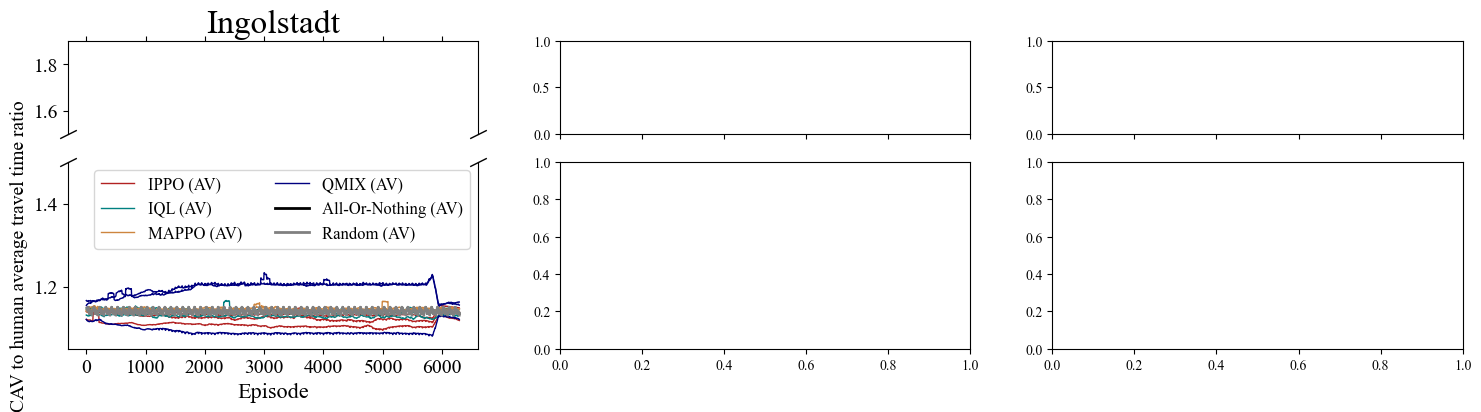

In [35]:
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'


# Set your actual parent directory here
parent_dir = os.path.abspath('results/scenario1')

# Define suffixes and their readable labels
group_suffixes = ['_ipp', '_iql', '_map', '_qmi']
suffix_labels = {
    '_ipp': 'IPPO',
    '_iql': 'IQL',
    '_map': 'MAPPO',
    '_qmi': 'QMIX'
}

# Define city prefixes and their readable names
city_prefixes = {
    'ing': 'Ingolstadt',
    #'pro': 'Provins',
    #'sai': 'Saint Arnoult'
}


# Define known baselines and labels
baseline_suffixes = ['_aon', '_ran']
baseline_labels = {
    '_aon': 'All-Or-Nothing',
    '_ran': 'Random'
}
baseline_styles = {
    '_aon': {'color': 'black', 'linestyle': '-'},
    '_ran': {'color': 'gray', 'linestyle': '-'}
}

# Define color palette for algorithms
colors = ["firebrick", "teal", "peru", "navy", "salmon", "slategray", "darkviolet"]
color_map = {suffix: colors[i] for i, suffix in enumerate(group_suffixes)}

# Group folders by city and algorithm
city_groups = defaultdict(lambda: defaultdict(list))
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            if folder.startswith(f'{city_prefix}_'):
                for suffix in group_suffixes:
                    if suffix in folder:
                        city_groups[city_prefix][suffix].append(folder_path)
                        break

# Collect baseline folders separately
baseline_groups = defaultdict(dict)
for folder in os.listdir(parent_dir):
    folder_path = os.path.abspath(os.path.join(parent_dir, folder))
    if os.path.isdir(folder_path):
        for city_prefix in city_prefixes:
            for baseline_suffix in baseline_suffixes:
                if folder == f'{city_prefix}{baseline_suffix}':
                    baseline_groups[city_prefix][baseline_suffix] = folder_path


# Create subplots (3 cities)
fig, axes = plt.subplots(2, 3, figsize=(18, 4), sharex='col', gridspec_kw={'height_ratios': [1, 2]})

for i, (city_prefix, alg_groups) in enumerate(city_groups.items()):
    ax_top = axes[0, i]   # for outliers
    ax_bottom = axes[1, i]  # for main data

    city_name = city_prefixes[city_prefix]
    avg_human_tt_list = []

    for suffix, folders in alg_groups.items():
        color = color_map.get(suffix, None)
        label = suffix_labels.get(suffix, suffix.upper())

        for idx, folder in enumerate(folders):
            av_run = get_travel_times_by_kind(folder, 'AV')
            human_run = get_travel_times_by_kind(folder, 'Human')

            human_slice = human_run[20:39]  # indices corresponding to episodes 100–200
            avg_human_tt = sum(human_slice) / len(human_slice)
            avg_human_tt_list.append(avg_human_tt)

            av_run = [val / avg_human_tt for val in av_run]

            if not av_run or not human_run:
                continue

            # Smooth and align x-axis
            av_smoothed = smooth_series(av_run, window=20)
            #human_smoothed = smooth_series(human_run, window=10)
            x = [i * 5 for i in range(len(av_smoothed))]

            
            ax_top.plot(x, av_smoothed, label=f'{label} (AV)' if idx == 0 else None, color=color, linewidth=1)
            ax_bottom.plot(x, av_smoothed, label=f'{label} (AV)' if idx == 0 else None, color=color, linewidth=1)

            # Plot each Human run with dashed line
            #ax.plot(x, human_smoothed, label=f'{label} (Human)' if idx == 0 else None, color=color, linestyle='--', linewidth=1)

    # Compute the avg human tt for all the algorithms
    avg_all_algos_humans_tt = sum(avg_human_tt_list) / len(avg_human_tt_list) 
            
    if city_prefix in baseline_groups:
        for baseline_suffix, folder_path in baseline_groups[city_prefix].items():
            av_times = get_travel_times_by_kind(folder_path, 'AV')
            if not av_times:
                continue
            
            av_times = [val / avg_all_algos_humans_tt for val in av_times]

            original_length = len(av_times)
            j = 0
            while len(av_times) < 5 * len(av_run):
                av_times.append(av_times[j % original_length])
                j += 1

            av_smoothed = smooth_series(av_times, window=10) ## maybe smooth more for baselines?
            x = [i * 5 for i in range(len(av_smoothed))]

            label = baseline_labels.get(baseline_suffix, baseline_suffix.upper())
            style = baseline_styles.get(baseline_suffix, {'color': 'black', 'linestyle': '--'})

            ax_top.plot(av_smoothed, label=f'{label} (AV)', **style, linewidth=2)
            ax_bottom.plot(av_smoothed, label=f'{label} (AV)', **style, linewidth=2)

    ax_top.spines.bottom.set_visible(False)
    ax_bottom.spines.top.set_visible(False)
    ax_top.xaxis.tick_top()
    ax_top.tick_params(labeltop=False)
    ax_bottom.xaxis.tick_bottom()

    d = .5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)

    ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, **kwargs)
    ax_bottom.plot([0, 1], [1, 1], transform=ax_bottom.transAxes, **kwargs)

    ax_bottom.set_ylim(1.05, 1.5)   # bottom axis shows main values
    ax_top.set_ylim(1.5, 1.9)      # top axis shows outliers

    ### Maybe add a line on y=1?
    #ax.axhline(y=1, color='r', linestyle='--', label='y = 1')  # Horizontal line at y=1

    ax_bottom.tick_params(axis='both', labelsize=14)
    ax_top.tick_params(axis='both', labelsize=14)
    #ax.set_yticks([1, 1.5])
    ax_top.set_title(f"{city_name}", fontsize=24)
    ax_bottom.set_xlabel("Episode", fontsize=16)
    #ax.grid(True)
    if i == 0:
        ax_bottom.set_ylabel("CAV to human average travel time ratio", fontsize=14)
        ax_bottom.legend(title="", loc = 'upper right', fontsize=12, ncol=2)

In [3]:
def plot_human_travel_times(ax, directories, algorithm_names):
    grouped_data = {}

    for i, d in enumerate(directories):
        episodes, times = get_av_travel_times(d, type="Human")
        if not episodes or not times:
            continue

        algo = algorithm_names[i]
        if algo not in grouped_data:
            grouped_data[algo] = {}
        for ep, val in zip(episodes, times):
            if ep not in grouped_data[algo]:
                grouped_data[algo][ep] = []
            grouped_data[algo][ep].append(val)

    # Plot one line + error band per algorithm
    for idx, (algo, data) in enumerate(grouped_data.items()):
        sorted_eps = sorted(data.keys())
        means = [np.mean(data[ep]) for ep in sorted_eps]
        stds = [np.std(data[ep]) for ep in sorted_eps]

        color = colors[idx % len(colors)]
        ax.plot(sorted_eps, means, color=color, linewidth=2.5, label=algo)
        ax.fill_between(
            sorted_eps,
            np.array(means) - np.array(stds),
            np.array(means) + np.array(stds),
            color=color,
            alpha=0.2
        )

    ax.axvline(x=6200, color='gray', linestyle='--', linewidth=2)
    ax.set_ylabel("Travel Time", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    #ax.legend(fontsize=10, loc='upper left')


In [4]:
def plot_av_travel_times(ax, directories, algorithm_names, smoothing_window=10, show_legend=False):
    grouped_data = {}

    for i, d in enumerate(directories):
        episodes, values = get_av_travel_times(d, type="AV")
        if not values:
            continue

        smoothed = smooth_data(values, smoothing_window)
        if len(episodes) > len(smoothed):
            episodes = episodes[:len(smoothed)]

        name = algorithm_names[i]
        if name not in grouped_data:
            grouped_data[name] = {}
        for ep, val in zip(episodes, smoothed):
            if ep not in grouped_data[name]:
                grouped_data[name][ep] = []
            grouped_data[name][ep].append(val)

    for idx, (name, data) in enumerate(grouped_data.items()):
        sorted_eps = sorted(data.keys())
        means = [np.mean(data[ep]) for ep in sorted_eps]
        stds = [np.std(data[ep]) for ep in sorted_eps]
        color = colors[idx % len(colors)]

        ax.plot(sorted_eps, means, color=color, linewidth=2.5, label=name)
        ax.fill_between(
            sorted_eps,
            np.array(means) - np.array(stds),
            np.array(means) + np.array(stds),
            color=color,
            alpha=0.2
        )

    ax.axvline(x=6200, color='gray', linestyle='--', linewidth=2)
    ax.set_xlabel("Episode Number", fontsize=12)
    ax.set_ylabel("Travel Time", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    if show_legend:
        ax.legend(fontsize=10, loc='upper left')


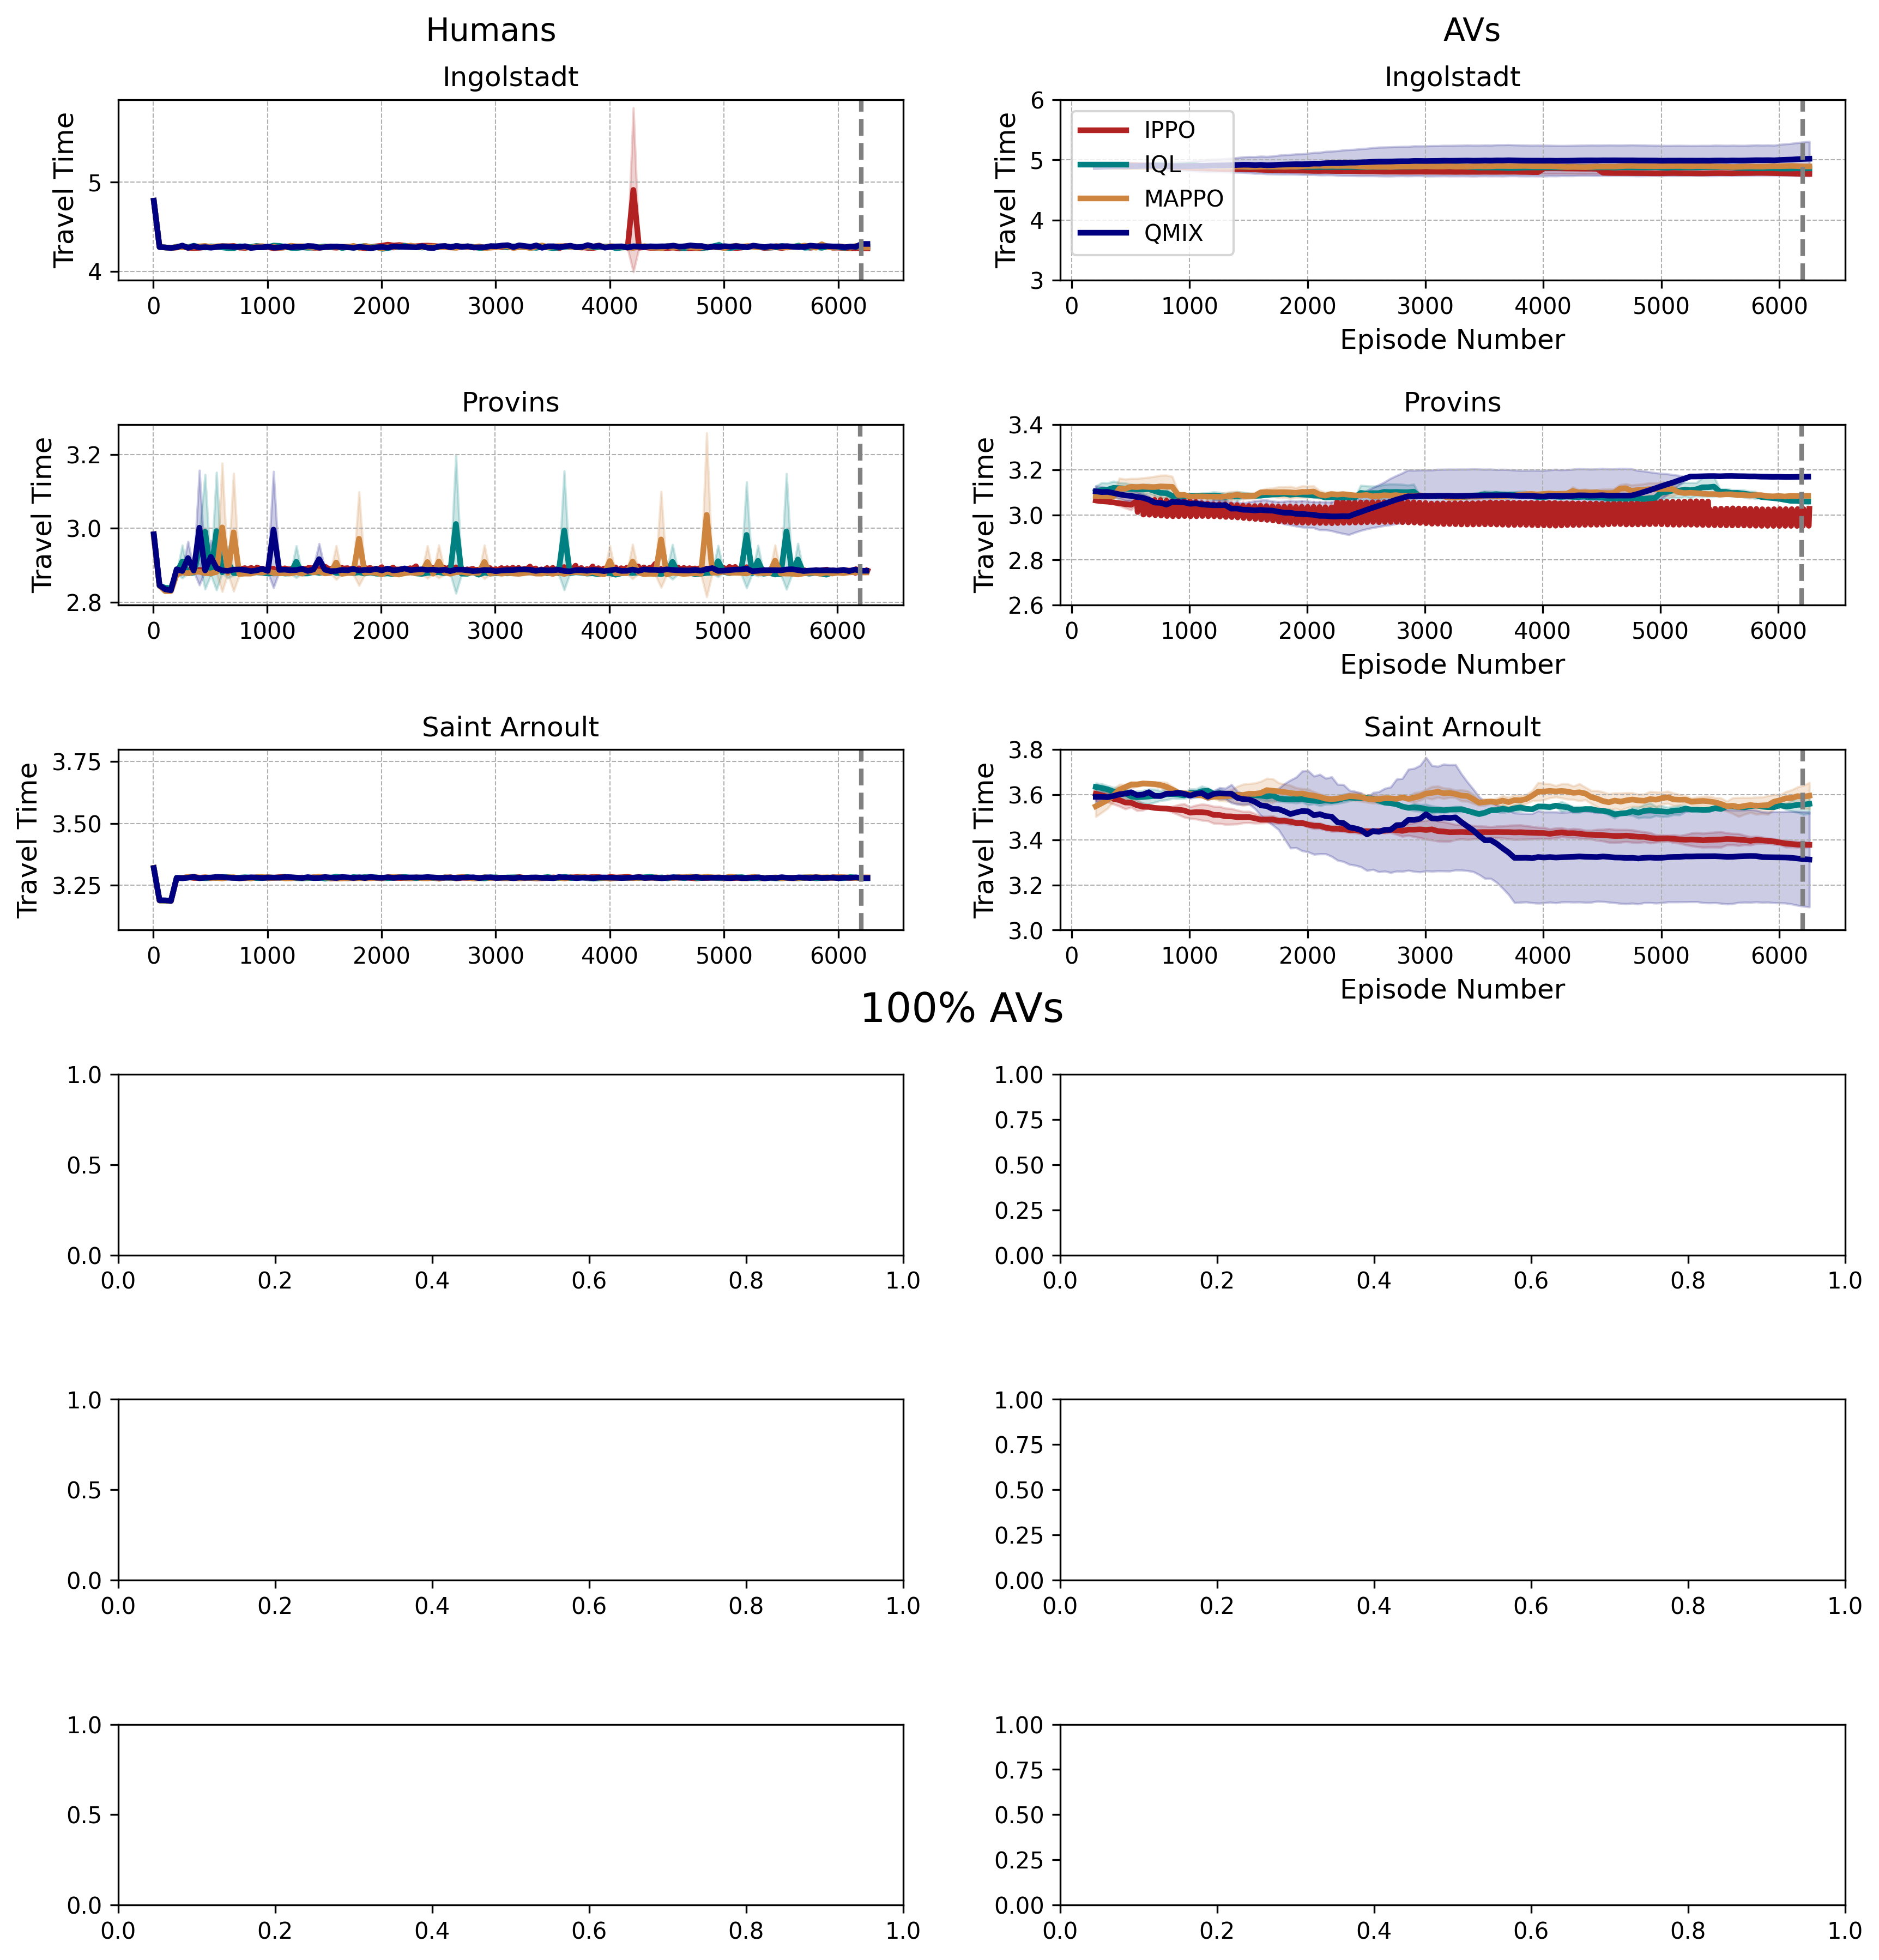

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize=(12, 12), dpi=300)

# --- Create 6x2 grid of subplots ---
axes_top = [[fig.add_subplot(6, 2, r * 2 + c + 1) for c in range(2)] for r in range(3)]
axes_bottom = [[fig.add_subplot(6, 2, (r + 3) * 2 + c + 1) for c in range(2)] for r in range(3)]

titles = ["Ingolstadt", "Provins", "Saint Arnoult"]
directories_param = [
    [
        "results/scenario1/ing_ipp_0/episodes", "results/scenario1/ing_ipp_1/episodes", "results/scenario1/ing_ipp_2/episodes",
        "results/scenario1/ing_iql_0/episodes", "results/scenario1/ing_iql_1/episodes", "results/scenario1/ing_iql_2/episodes",
        "results/scenario1/ing_map_0/episodes", "results/scenario1/ing_map_1/episodes", "results/scenario1/ing_map_2/episodes",
        "results/scenario1/ing_qmi_0/episodes", "results/scenario1/ing_qmi_1/episodes", "results/scenario1/ing_qmi_2/episodes",
    ],
    [
        "results/scenario1/pro_ipp_0/episodes", "results/scenario1/pro_ipp_1/episodes", "results/scenario1/pro_ipp_2/episodes",
        "results/scenario1/pro_iql_0/episodes", "results/scenario1/pro_iql_1/episodes", "results/scenario1/pro_iql_2/episodes",
        "results/scenario1/pro_map_0/episodes", "results/scenario1/pro_map_1/episodes", "results/scenario1/pro_map_2/episodes",
        "results/scenario1/pro_qmi_0/episodes", "results/scenario1/pro_qmi_1/episodes", "results/scenario1/pro_qmi_2/episodes",
    ],
    [
        "results/scenario1/sai_ipp_0/episodes", "results/scenario1/sai_ipp_1/episodes", "results/scenario1/sai_ipp_2/episodes",
        "results/scenario1/sai_iql_0/episodes", "results/scenario1/sai_iql_1/episodes", "results/scenario1/sai_iql_2/episodes",
        "results/scenario1/sai_map_0/episodes", "results/scenario1/sai_map_1/episodes", "results/scenario1/sai_map_2/episodes",
        "results/scenario1/sai_qmi_0/episodes", "results/scenario1/sai_qmi_1/episodes", "results/scenario1/sai_qmi_2/episodes",
    ],
]

"""directories_param2 = [
    [
        "results/ing_ipp2_0/episodes", "results/ing_ipp2_1/episodes", "results/ing_ipp2_2/episodes",
        "results/ing_iql2_0/episodes", "results/ing_iql2_1/episodes", "results/ing_iql2_2/episodes",
        "results/ing_map2_0/episodes", "results/ing_map2_1/episodes", "results/ing_map2_2/episodes",
        "results/ing_qmi2_0/episodes", "results/ing_qmi2_1/episodes", "results/ing_qmi2_2/episodes",
    ],
    [
        "results/pro_ipp2_0/episodes", "results/pro_ipp2_1/episodes", "results/pro_ipp2_2/episodes",
        "results/pro_iql2_0/episodes", "results/pro_iql2_1/episodes", "results/pro_iql2_2/episodes",
        "results/pro_map2_0/episodes", "results/pro_map2_1/episodes", "results/pro_map2_2/episodes",
        "results/pro_qmi2_0/episodes", "results/pro_qmi2_1/episodes", "results/pro_qmi2_2/episodes",
    ],
    [
        "results/sai_ipp2_0/episodes", "results/sai_ipp2_1/episodes", "results/sai_ipp2_2/episodes",
        "results/sai_iql2_0/episodes", "results/sai_iql2_1/episodes", "results/sai_iql2_2/episodes",
        "results/sai_map2_0/episodes", "results/sai_map2_1/episodes", "results/sai_map2_2/episodes",
        "results/sai_qmi2_0/episodes", "results/sai_qmi2_1/episodes", "results/sai_qmi2_2/episodes",
    ],
]"""
algorithm_names = ["IPPO"] * 3 + ["IQL"] * 3 + ["MAPPO"] * 3 + ["QMIX"] * 3

# --- Plot data into each grid ---
for i in range(3):
    # Top (human vs AV)
    plot_human_travel_times(axes_top[i][0], directories_param[i], algorithm_names)
    plot_av_travel_times(
        axes_top[i][1],
        directories=directories_param[i],
        algorithm_names=algorithm_names,
        smoothing_window=10,
        show_legend=(i == 0)
    )

    axes_top[i][0].set_title(f"{titles[i]}", fontsize=12)
    axes_top[i][1].set_title(f"{titles[i]}", fontsize=12)

    # Bottom (duplicate)
    """plot_human_travel_times(axes_bottom[i][0], directories_param2[i], algorithm_names)
    plot_av_travel_times(
        axes_bottom[i][1],
        directories=directories_param2[i],
        algorithm_names=algorithm_names,
        smoothing_window=10,
        show_legend=False
    )

    axes_bottom[i][0].set_title(f"{titles[i]}", fontsize=12)
    axes_bottom[i][1].set_title(f"{titles[i]}", fontsize=12)"""

for row_axes in [axes_top, axes_bottom]:
    for i in range(3):  # For each row
        ax_left = row_axes[i][0]   # Human plot
        ax_right = row_axes[i][1]  # AV plot

        # Get y-limits from both axes
        ymin = min(ax_left.get_ylim()[0], ax_right.get_ylim()[0])
        ymax = max(ax_left.get_ylim()[1], ax_right.get_ylim()[1])

        # Set same y-limits and y-ticks
        ax_left.set_ylim(ymin, ymax)
        ax_right.set_ylim(ymin, ymax)
        ax_right.set_yticks(ax_left.get_yticks())  # Ensure matching ticks

"""fig.text(
    0.5,        # x center (50% across)
    1,       # y position (just between top and bottom)
    "40% AVs",
    ha='center',
    fontsize=18,
)"""

fig.text(
    0.25,        # x center (50% across)
    1,       # y position (just between top and bottom)
    "Humans",
    ha='center',
    fontsize=14,
)

fig.text(
    0.75,        # x center (50% across)
    1,       # y position (just between top and bottom)
    "AVs",
    ha='center',
    fontsize=14,
)

fig.text(
    0.49,        # x center (50% across)
    0.5,       # y position (just between top and bottom)
    "100% AVs",
    ha='center',
    fontsize=18,
)


# --- Manual layout adjustment ---
fig.subplots_adjust(
    left=0.06,
    right=0.94,
    top=0.97,
    bottom=0.05,
    hspace=0.8,
    wspace=0.2
)